In [ ]:
# predict probability that any given game will result in a regulation tie

In [1]:
import pandas as pd


In [3]:
# write final modeling data to excel
modeling_data = pd.read_excel(r'data/modeling_data.xlsx', header=0)

# inspect
modeling_data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3381 entries, 0 to 3380
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          3381 non-null   datetime64[ns]
 1   Season        3381 non-null   int64         
 2   Game_ID       3381 non-null   object        
 3   Home_Team     3381 non-null   object        
 4   Away_Team     3381 non-null   object        
 5   Odds_1        3256 non-null   float64       
 6   Odds_X        3256 non-null   float64       
 7   Odds_2        3256 non-null   float64       
 8   Reg_Tie       3381 non-null   bool          
 9   Month         3381 non-null   object        
 10  Day_of_Week   3381 non-null   object        
 11  Conf_Matchup  3381 non-null   bool          
 12  Div_Matchup   3381 non-null   bool          
 13  Conf_Pair     3290 non-null   object        
 14  Div_Pair      3290 non-null   object        
 15  Team_Pair     3381 non-null   object  

In [4]:
# set season as categorical
modeling_data['Season'] = modeling_data['Season'].astype('str')
modeling_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3381 entries, 0 to 3380
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          3381 non-null   datetime64[ns]
 1   Season        3381 non-null   object        
 2   Game_ID       3381 non-null   object        
 3   Home_Team     3381 non-null   object        
 4   Away_Team     3381 non-null   object        
 5   Odds_1        3256 non-null   float64       
 6   Odds_X        3256 non-null   float64       
 7   Odds_2        3256 non-null   float64       
 8   Reg_Tie       3381 non-null   bool          
 9   Month         3381 non-null   object        
 10  Day_of_Week   3381 non-null   object        
 11  Conf_Matchup  3381 non-null   bool          
 12  Div_Matchup   3381 non-null   bool          
 13  Conf_Pair     3290 non-null   object        
 14  Div_Pair      3290 non-null   object        
 15  Team_Pair     3381 non-null   object  

In [5]:
# inspect count of ties
modeling_data['Reg_Tie'].value_counts()

Reg_Tie
False    2667
True      714
Name: count, dtype: int64

In [21]:
# drop na to make life easier
modeling_data = modeling_data.dropna()
modeling_data.info()

# inspect count of ties
modeling_data['Reg_Tie'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 3174 entries, 111 to 3380
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          3174 non-null   datetime64[ns]
 1   Season        3174 non-null   object        
 2   Game_ID       3174 non-null   object        
 3   Home_Team     3174 non-null   object        
 4   Away_Team     3174 non-null   object        
 5   Odds_1        3174 non-null   float64       
 6   Odds_X        3174 non-null   float64       
 7   Odds_2        3174 non-null   float64       
 8   Reg_Tie       3174 non-null   bool          
 9   Month         3174 non-null   object        
 10  Day_of_Week   3174 non-null   object        
 11  Conf_Matchup  3174 non-null   bool          
 12  Div_Matchup   3174 non-null   bool          
 13  Conf_Pair     3174 non-null   object        
 14  Div_Pair      3174 non-null   object        
 15  Team_Pair     3174 non-null   object     

Reg_Tie
False    2501
True      673
Name: count, dtype: int64

In [22]:
# designate response variable
response_ = 'Reg_Tie'

# inspect value counts: ties seem to happen 25% of the time roughly
modeling_data[['Season', response_]].value_counts().sort_index()


Season  Reg_Tie
2023    False      1043
        True        274
2024    False      1190
        True        307
2025    False       268
        True         92
Name: count, dtype: int64

In [23]:
# find ideal sample size to test on all of 2025
samp_size_2025 = modeling_data[modeling_data['Season']=='2025'].shape[0] / modeling_data.shape[0]
print(f'Sample size for 2025 season: {samp_size_2025:.2%}')

modeling_data['Season'].value_counts()

Sample size for 2025 season: 11.34%


Season
2024    1497
2023    1317
2025     360
Name: count, dtype: int64

In [25]:
# list of drop cols that won't be used in modeling
drop_cols = ['Game_ID', 'Date', 'Home_Team', 'Away_Team']

# leave these commented out for future insertion in list above
# 'Conf_Pair',  'Div_Pair', 

# get P1-P3 cols and drop
p_cols = [col for col in modeling_data.columns if 'P1_' in col or 'P2_' in col or 'P3_' in col]
drop_cols = drop_cols + p_cols

# get X matrix
X = modeling_data.drop(columns=drop_cols + [response_])
X.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3174 entries, 111 to 3380
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Season        3174 non-null   object 
 1   Odds_1        3174 non-null   float64
 2   Odds_X        3174 non-null   float64
 3   Odds_2        3174 non-null   float64
 4   Month         3174 non-null   object 
 5   Day_of_Week   3174 non-null   object 
 6   Conf_Matchup  3174 non-null   bool   
 7   Div_Matchup   3174 non-null   bool   
 8   Conf_Pair     3174 non-null   object 
 9   Div_Pair      3174 non-null   object 
 10  Team_Pair     3174 non-null   object 
dtypes: bool(2), float64(3), object(6)
memory usage: 254.2+ KB


In [26]:
# isolate binary response
y_binary = modeling_data[response_].astype(bool) # make sure that this is bool

# inspect y
y_binary.info()

# get class weights to deal with imbalanced dataset
from collections import Counter

counts = Counter(y_binary)
total = sum(counts.values())
class_weights = [total / counts[cls] for cls in sorted(counts)]

# print class weights
print(counts)
print('class weights:', class_weights)
print('pos rate:', y_binary.mean()) 

<class 'pandas.core.series.Series'>
Index: 3174 entries, 111 to 3380
Series name: Reg_Tie
Non-Null Count  Dtype
--------------  -----
3174 non-null   bool 
dtypes: bool(1)
memory usage: 27.9 KB
Counter({False: 2501, True: 673})
class weights: [1.2690923630547781, 4.716196136701337]
pos rate: 0.21203528670447386


In [39]:
from sklearn.model_selection import train_test_split

# 1. Train/test split (preserve time order)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, train_size=0.98, shuffle=False
)


In [40]:
# fit a single catboost classifier with defaults
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score

# 2. Define categorical features
cat_features = ['Season', 'Month', 'Day_of_Week', 'Conf_Pair', 'Div_Pair', 'Team_Pair']
# cat_features = ['Season', 'Month', 'Day_of_Week', 'Start_Hour_Group']
# cat_features = ['Season', 'Month', 'Day_of_Week']

# 3. Create Pools
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# 4. Train model with reasonable defaults
basic_model = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.03,
    class_weights=class_weights, # to fix class imbalance
    boosting_type='Ordered',     # ensure data is ordered
    verbose=100
)

# Fit with early stopping
basic_model.fit(
    train_pool,
    eval_set=test_pool,
    early_stopping_rounds=100,
    use_best_model=True
)

# 5. Predict and evaluate
y_pred = basic_model.predict(test_pool)

# 5. Predict and evaluate proba
y_pred_proba = basic_model.predict_proba(test_pool)[:, 1]

# classification report
print(classification_report(y_test, y_pred))

# calc auc, accuracy, and pos rate
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
pos_rate = y_test.mean()

print('acc:', acc)
print('auc:', auc)
print('pos_rate:', pos_rate)


0:	learn: 0.6931469	test: 0.6931617	best: 0.6931617 (0)	total: 23.2ms	remaining: 34.8s
100:	learn: 0.6872858	test: 0.6893784	best: 0.6893749 (96)	total: 3.9s	remaining: 54.1s
200:	learn: 0.6797760	test: 0.6852749	best: 0.6850078 (149)	total: 7.71s	remaining: 49.8s
300:	learn: 0.6744003	test: 0.6867231	best: 0.6837142 (257)	total: 10.8s	remaining: 43s
400:	learn: 0.6487498	test: 0.6856896	best: 0.6824775 (355)	total: 16s	remaining: 43.8s
500:	learn: 0.6254634	test: 0.6908054	best: 0.6814580 (449)	total: 21s	remaining: 41.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6814580125
bestIteration = 449

Shrink model to first 450 iterations.
              precision    recall  f1-score   support

       False       0.78      0.38      0.51        47
        True       0.29      0.71      0.41        17

    accuracy                           0.47        64
   macro avg       0.54      0.54      0.46        64
weighted avg       0.65      0.47      0.49        64

acc: 

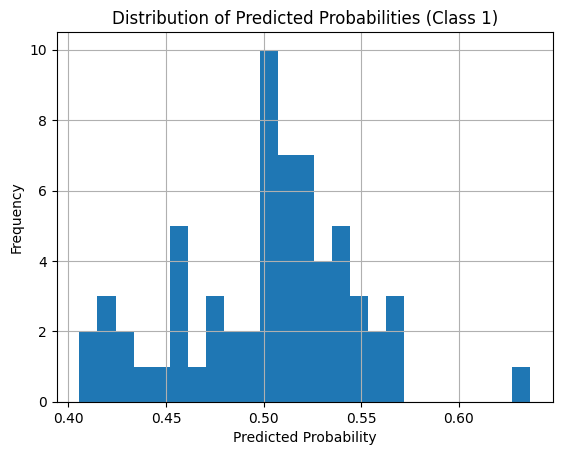

In [41]:
import matplotlib.pyplot as plt

# get y_probs and plot
y_probs = basic_model.predict_proba(test_pool)[:, 1]

plt.hist(y_probs, bins=25)
plt.title("Distribution of Predicted Probabilities (Class 1)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
# 5. Set your custom positive threshold
custom_threshold = 0.503 # You can change this value

# 6. Predict probabilities and apply threshold
y_probs = basic_model.predict_proba(test_pool)[:, 1]
y_pred_custom = (y_probs >= custom_threshold).astype(int)

# 7. Evaluate
print(f"\nConfusion Matrix at threshold {custom_threshold}:")
print(confusion_matrix(y_test, y_pred_custom))
print(f"\nClassification Report at threshold {custom_threshold}:")
print(classification_report(y_test, y_pred_custom))

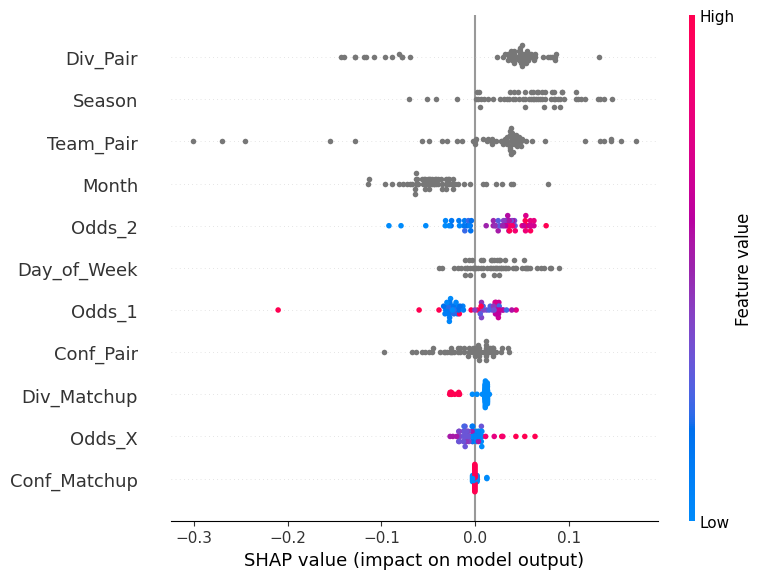

In [42]:
import numpy as np
import pandas as pd
import shap

# ---- Existing model training code remains unchanged ----

# 6. Get SHAP values from the model
shap_values = basic_model.get_feature_importance(
    data=test_pool,
    type='ShapValues'  # returns SHAP values + expected value
)

# 7. Extract feature names
feature_names = X_test.columns.tolist()

# 8. Create DataFrame for SHAP values (excluding last column which is base value)
shap_df = pd.DataFrame(shap_values[:, :-1], columns=feature_names)

# 9. Optional: Summary plot (global feature importance)
shap.summary_plot(shap_values[:, :-1], X_test, feature_names=feature_names)


In [32]:
# 10. Calculate mean absolute SHAP value for each feature
shap_mean_importance = shap_df.abs().mean().sort_values(ascending=False)

# 11. Display as DataFrame
shap_ranking_df = pd.DataFrame({
    'Feature': shap_mean_importance.index,
    'MeanAbsSHAP': shap_mean_importance.values
})

# update my code to show all rows of shap ranking df
pd.set_option('display.max_rows', None)

# Show top 20 most important features
print(shap_ranking_df.head(200))

         Feature  MeanAbsSHAP
0      Team_Pair     0.002328
1    Day_of_Week     0.001033
2       Div_Pair     0.000037
3          Month     0.000025
4         Odds_1     0.000018
5         Odds_X     0.000000
6         Season     0.000000
7   Conf_Matchup     0.000000
8         Odds_2     0.000000
9      Conf_Pair     0.000000
10   Div_Matchup     0.000000


In [ ]:
import joblib

# write model to pkl file
joblib.dump(basic_model, 'model/catboost_model_reg_tie.pkl')
